In [2]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [3]:
fileprefix = "pilot_3" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [4]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
scarcity_level = 1.0
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    avgClickLevel = []
    trialClicksL1 = []
    trialClicksL2 = []
    trialClicksL3 = []
    trialClicksL4 = []
    trialClicksL5 = []
    rewardsWithheld = []
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    whatStrategy = ""
    strategyImprove = ""
    difficult = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
    
        
        # Start mouselab trials
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('large_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    try:
                        mEnv.step(int(click))
                    except:
                        continue
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Matching click number to node depth
                clicksL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL2 = len([c for c in clicks if int(c) in [2,13,24]])
                clicksL3 = len([c for c in clicks if int(c) in [3,14,25]])
                clicksL4 = len([c for c in clicks if int(c) in [4,8,15,19,26,30]])
                clicksL5 = len([c for c in clicks if int(c) in [5,6,7,9,10,11,16,17,18,20,21,22,27,28,29]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3 + 4*clicksL4 + 5*clicksL5)/len(clicks)
                except:
                    avgLevel = 0
                
                trialClicksL1.append(clicksL1)
                trialClicksL2.append(clicksL2)
                trialClicksL3.append(clicksL3)
                trialClicksL4.append(clicksL4)
                trialClicksL5.append(clicksL5)
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']/(1.0 if participant['condition'] == 0 else scarcity_level)
                expectedScores.append(planQuality)
                
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        last_trial = trial

    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "clicksL1": trialClicksL1,
        "clicksL2": trialClicksL2,
        "clicksL3": trialClicksL3,
        "clicksL4": trialClicksL4,
        "clicksL5": trialClicksL5,
        "demographicsAvailable": demographicsAvailable
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = + part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

6160ccb0810a73f90ef4c5e7
61066e991d3b7cc1eacf2a53
6310b43bd9f974e46765836b
6116422e3fd768e0eb82fa98
5ed3b2b3397ebb01e2c64923
5e0d4d2d7605fe4d7fba6f5e
612296b87416dfaf670907cd
5c0fdebfdfbb180001c32177
No data
59c93d675e01580001977815
601c1a00178c02637f1659a1
60dec770e794837d68214ae1
5fc9ec3d0990d4501dfd7e05
6120b4fca2fedeb88787374c
610b743b3f893111e9fa3986
5fa061eeb1f28d08b4e40501
60e6e91bf2974c65f8296342
60dfcb70b6cede357105e6ed
5c4f4ce19eeaf00001598126
616c4409a2bcfe1fdb942117
60d77edd5ede206b58b8b9c8
5d616bd447787f000175cd9e
60daf06339acaaccef1a00932
5fdfd04b9bf07d83b2e5f780
5ea98f445ef6ee093f4f05ec
60f2be10f84eb35558463468
61570d5eb2963a6d6ea3719a
60475f804d6ac923410a4b12
5e083e0a35a7a5178670e03e
616eb493bb7e4ab4fa1de8d4
611e1cb0e8882a2a1e9f456d
60d101464180f5f5cd211e77
5efbe7a1cae4551978ab74bd
5c38658f3ce2c800011225ce
60e2fbb1eec0ddbbe525aa49
61224ccef1ce5b2169df0f44
610401cb3f635573ecf3656d
614dc91f0e0e6092ccbca846
6482f8b93bfd2bc0f245e504
5ee3348f8cfe2d49e6dc98ff
60fd8d7167e1b230

In [10]:
# Compiling all data into trial data

add_fields = ["trialScores", "expectedScores", "numClicks", "avgClickLevel", "trialNumbers", "condition", "workerId",
             "clicksL1", "clicksL2", "clicksL3", "clicksL4" ,"clicksL5"]

all_trial_data = {field: [] for field in add_fields}

count = 0;

def format_field_val(field, part):
    if field == 'workerId':
        return [part['workerId']] * len(part['trialScores'])
    elif field == 'trialNumbers':
        return list(range(1,len(part['trialScores'])+1))
    elif field == 'condition':
        return [int(part['condition'])] * len(part['trialScores'])
    else:
        return part[field]

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30,40]:
        print(part['condition'], part['workerId'], "MDP Data Incomplete")
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    count += 1
    for field in add_fields:
        all_trial_data[field] += format_field_val(field, part)    

all_trials_df = pd.DataFrame(all_trial_data)


1 61066e991d3b7cc1eacf2a53 Demographics missing
0 5ed3b2b3397ebb01e2c64923 MDP Data Incomplete
0 59c93d675e01580001977815 MDP Data Incomplete
0 601c1a00178c02637f1659a1 MDP Data Incomplete
0 610b743b3f893111e9fa3986 Demographics missing
0 60daf06339acaaccef1a00932 MDP Data Incomplete
0 61570d5eb2963a6d6ea3719a MDP Data Incomplete
0 60e2fbb1eec0ddbbe525aa49 MDP Data Incomplete
0 61224ccef1ce5b2169df0f44 MDP Data Incomplete
0 6482f8b93bfd2bc0f245e504 MDP Data Incomplete
0 5f98383ec3a3c80b6c8190a6 MDP Data Incomplete
1 6005a70567c8e981ead530b5 MDP Data Incomplete
0 60fdcb486e092bc7c1d9c748 MDP Data Incomplete
1 60f579085ebf24f9c80f223e MDP Data Incomplete
1 608690e9fc999a08f141b708 MDP Data Incomplete
0 616cdeebd38a9ca9cdc4b481 MDP Data Incomplete
0 6070c2f8aa9a08d466b86d5c MDP Data Incomplete


In [11]:
all_trials_df

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            32.2            32.2         17       2.882353             1  \
1            25.6            43.6         21       3.190476             2   
2            53.8            53.8         23       3.652174             3   
3            43.2            43.2         27       3.666667             4   
4           -48.6            56.4         19       4.000000             5   
...           ...             ...        ...            ...           ...   
2235         47.0             0.0          0       0.000000            36   
2236        -40.0             0.0          0       0.000000            37   
2237         24.0             0.0          0       0.000000            38   
2238        -20.0             0.0          0       0.000000            39   
2239        -98.0             0.0          0       0.000000            40   

      condition                  workerId  clicksL1  clicksL2  clicksL3   
0             0  6160ccb0810a73f90ef4c5e7         3         3         3  \
1             0  6160ccb0810a73f90ef4c5e7         3         3         3   
2             0  6160ccb0810a73f90ef4c5e7         2         2         3   
3             0  6160ccb0810a73f90ef4c5e7         2         2         2   
4             0  6160ccb0810a73f90ef4c5e7         1         0         0   
...         ...                       ...       ...       ...       ...   
2235          1  5ebf17adf3c3511355882e8a         0         0         0   
2236          1  5ebf17adf3c3511355882e8a         0         0         0   
2237          1  5ebf17adf3c3511355882e8a         0         0         0   
2238          1  5ebf17adf3c3511355882e8a         0         0         0   
2239          1  5ebf17adf3c3511355882e8a         0         0         0   

      clicksL4  clicksL5  
0            4         3  
1            6         5  
2            6         9  
3            3        15  
4            0        15  
...        ...       ...  
2235         0         0  
2236         0         0  
2237         0         0  
2238         0         0  
2239         0         0  

[2240 rows x 12 columns]

## Analyzing Inferred Strategies

In [6]:
# Defining paths

# CM inferred strategies
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

scarce_inferred = inferred_path + "/scarcity_scarce/strategies.pkl"
control_inferred = inferred_path + "/scarcity_control/strategies.pkl"

# Output files for strategies
scarce_file = results_path + "/mouselab-mdp-final-scarce.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_scarce_path = results_path + "/cm/strategy_scores/scarcity_scarce_clickcost_0.25_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/scarcity_control_clickcost_1.0_strategy_scores.pkl"


scarce_df_rows = []
control_df_rows = []

In [7]:
# Reading csv files

with open(scarce_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        scarce_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

FileNotFoundError: [Errno 2] No such file or directory: '../results/mouselab-mdp-final-scarce.csv'

In [ ]:
# Reading inferred strategies

with open(scarce_inferred, 'rb') as f:
    scarce_strategies = pickle.load(f)
    
with open(control_inferred, 'rb') as f:
    control_strategies = pickle.load(f)

In [ ]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'scarce']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [ ]:
for workerId, stratList in scarce_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [ ]:
# Reading strategy scores

with open(strategy_scores_scarce_path, 'rb') as file:
    strategy_scores_scarce = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control = pickle.load(file)


In [ ]:
# Creating the strategy score dataframes

strategy_scores_scarce_list = [[k,v] for k,v in strategy_scores_scarce.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

scarce_cluster_df = pd.DataFrame(strategy_scores_scarce_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
scarce_cluster_df['scoreScaled'] = (scarce_cluster_df['score'] - scarce_cluster_df['score'].min()) / (scarce_cluster_df['score'].max() - scarce_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())



In [ ]:
# Cluster the strategy scores

scarce_clusters = scipy.cluster.vq.kmeans(scarce_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
scarce_cluster_centers = scarce_clusters[0]

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
control_cluster_centers = control_clusters[0]

In [ ]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

scarce_clusters_repeated = np.repeat(np.expand_dims(scarce_cluster_centers, axis=0), len(scarce_cluster_df), axis=0)
scarce_cluster_distances = (scarce_clusters_repeated - np.repeat(np.expand_dims(np.array(scarce_cluster_df['scoreScaled']), axis=1),repeats=len(scarce_cluster_centers), axis=1))**2
scarce_cluster_labels = np.argmin(scarce_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [ ]:
# Create dictionary of cluster labels:

scarce_cluster_dict = { strat: cluster for (strat, cluster) in zip(scarce_cluster_df.strategy, scarce_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


In [ ]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['scarce'] == 0:
        strategy_df.at[idx, 'cluster'] = scarce_cluster_dict[row['strategy']-1]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_scarce[row['strategy']-1] / scarcity_level
    else:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']-1]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']-1]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [ ]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [ ]:
all_trials_df

In [12]:
# Data to use for the remainder of the analysis

model_save_folder = "../results/model_sim_data/"
control_model = "2.0.3.0.0"
scarce_model = "2.0.3.0.0"
num_simulations = 1
model_file_name = f"c{control_model}_s{scarce_model}_{num_simulations}.csv"

use_model_data = False

if use_model_data:
    filtered_data = pd.read_csv(model_save_folder + model_file_name)
else:
    filtered_data = all_trials_df

In [13]:
filtered_data

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            32.2            32.2         17       2.882353             1  \
1            25.6            43.6         21       3.190476             2   
2            53.8            53.8         23       3.652174             3   
3            43.2            43.2         27       3.666667             4   
4           -48.6            56.4         19       4.000000             5   
...           ...             ...        ...            ...           ...   
2235         47.0             0.0          0       0.000000            36   
2236        -40.0             0.0          0       0.000000            37   
2237         24.0             0.0          0       0.000000            38   
2238        -20.0             0.0          0       0.000000            39   
2239        -98.0             0.0          0       0.000000            40   

      condition                  workerId  clicksL1  clicksL2  clicksL3   
0             0  6160ccb0810a73f90ef4c5e7         3         3         3  \
1             0  6160ccb0810a73f90ef4c5e7         3         3         3   
2             0  6160ccb0810a73f90ef4c5e7         2         2         3   
3             0  6160ccb0810a73f90ef4c5e7         2         2         2   
4             0  6160ccb0810a73f90ef4c5e7         1         0         0   
...         ...                       ...       ...       ...       ...   
2235          1  5ebf17adf3c3511355882e8a         0         0         0   
2236          1  5ebf17adf3c3511355882e8a         0         0         0   
2237          1  5ebf17adf3c3511355882e8a         0         0         0   
2238          1  5ebf17adf3c3511355882e8a         0         0         0   
2239          1  5ebf17adf3c3511355882e8a         0         0         0   

      clicksL4  clicksL5  
0            4         3  
1            6         5  
2            6         9  
3            3        15  
4            0        15  
...        ...       ...  
2235         0         0  
2236         0         0  
2237         0         0  
2238         0         0  
2239         0         0  

[2240 rows x 12 columns]

# Visualizing Data

## Expected Scores

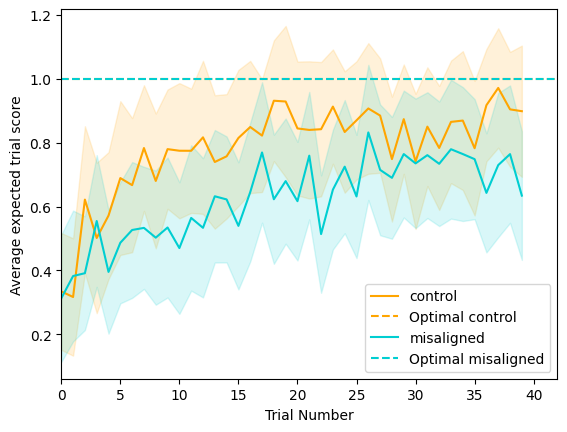

In [54]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "expectedScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control","misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



## Actual Scores

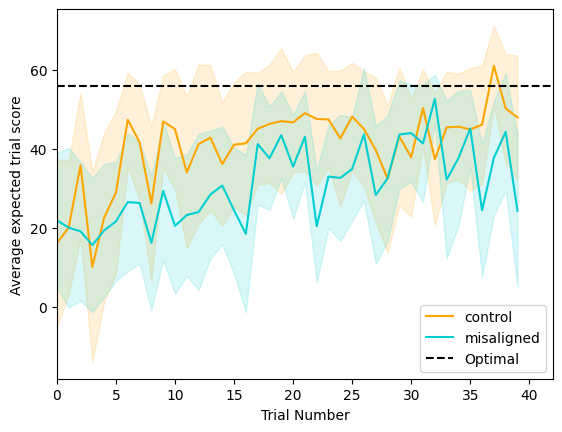

In [15]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "trialScores"
optimal_env_score = 55.89

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }

plot_se = True

plot_conds = ["control","misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



## Clicks

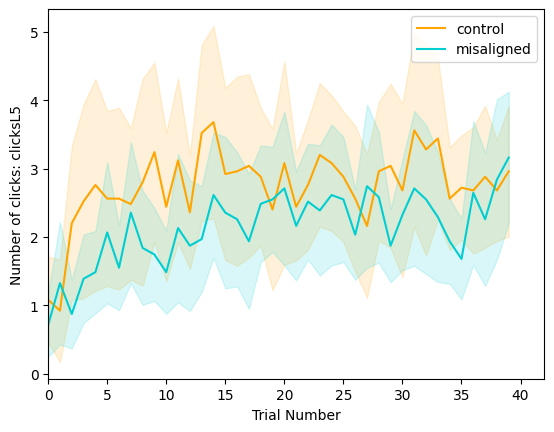

In [18]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "clicksL5"
optimal_env_score = 5

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }

plot_se = True

plot_conds = ["control","misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend()
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Number of clicks: " + performance_metric)
plt.show()



## Strategy Scores

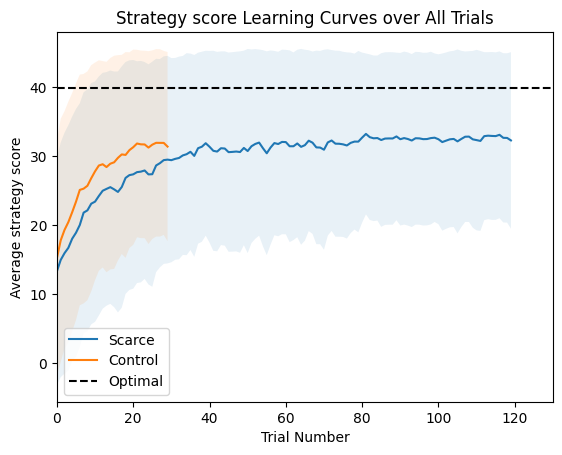

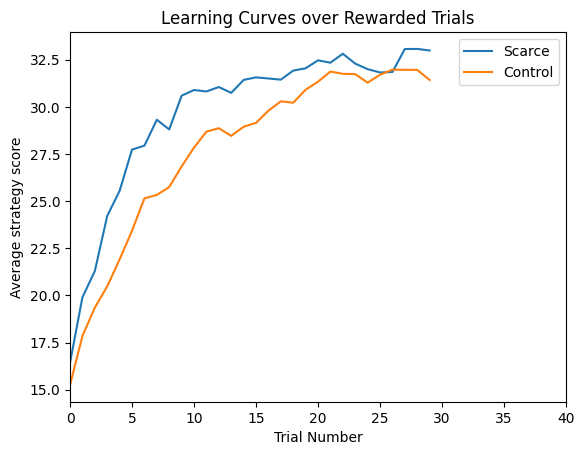

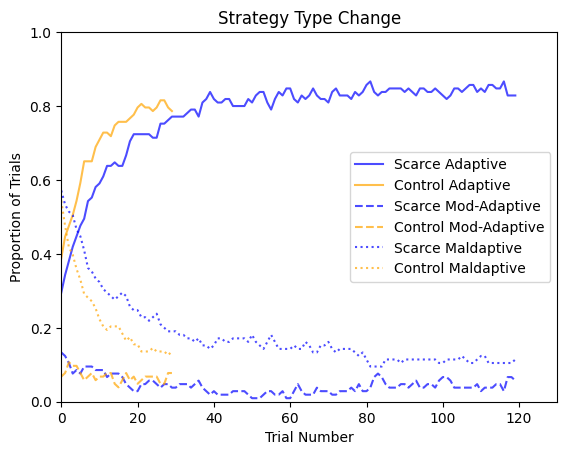

In [327]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean()["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std()["strategyScores"])
control_data = np.array(control_trial_group.mean()["strategyScores"])
control_data_sd = np.array(control_trial_group.std()["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())
#control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["strategyScores"])
#control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["strategyScores"])

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["strategyScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["strategyScores"])

plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of Trials")
plt.show()


# 0.1 - Transforming Response Data

In [19]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [20]:
# Selecting the response variable

response_vars = ['expectedScores', 'avgClickLevel']

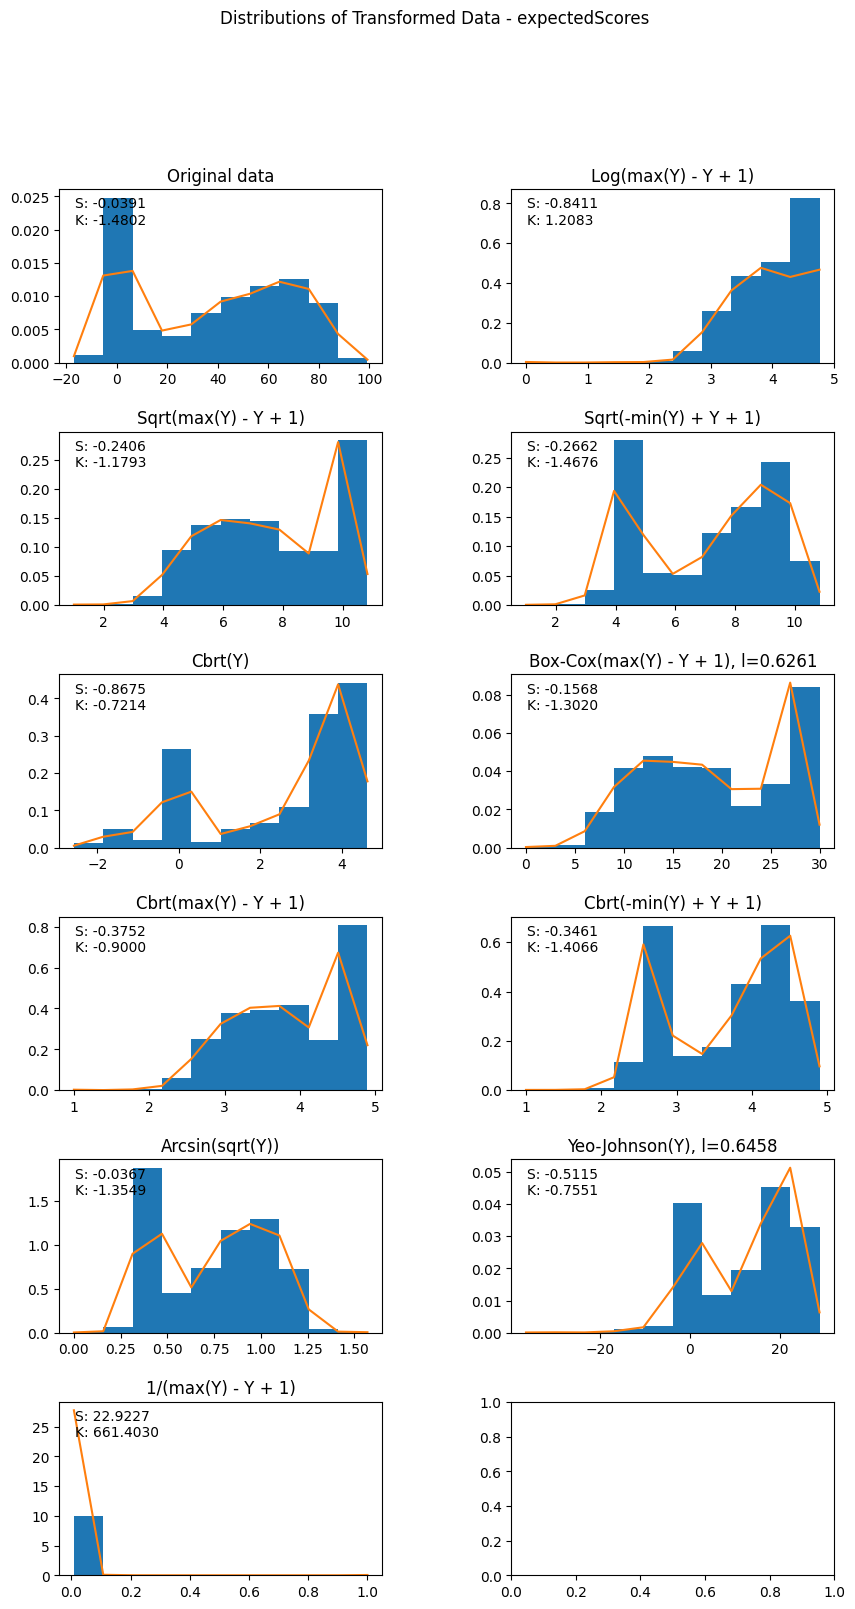

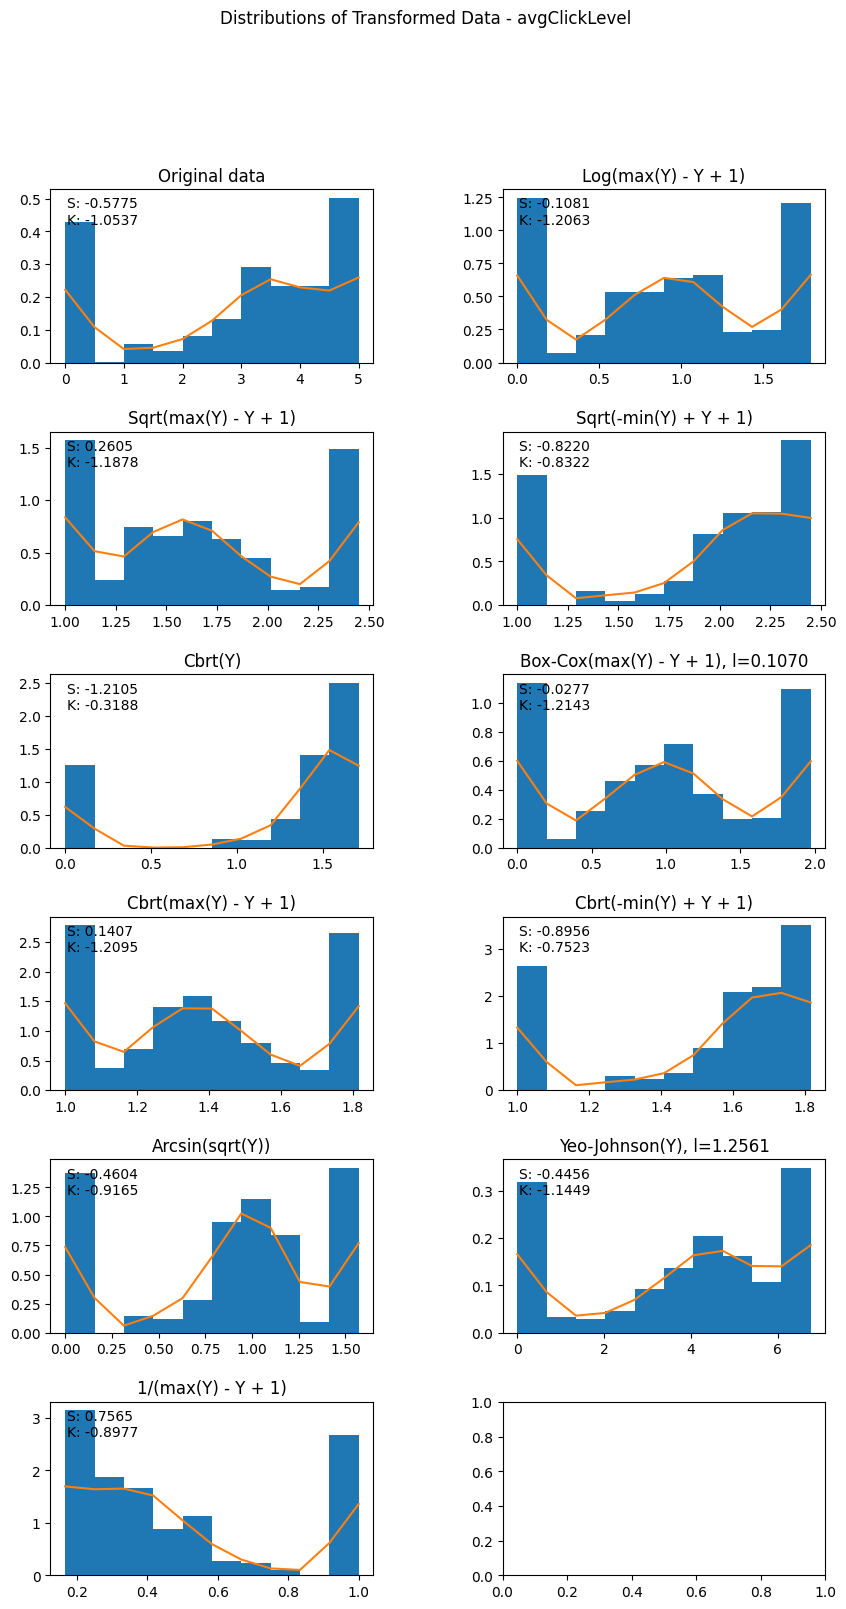

In [21]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

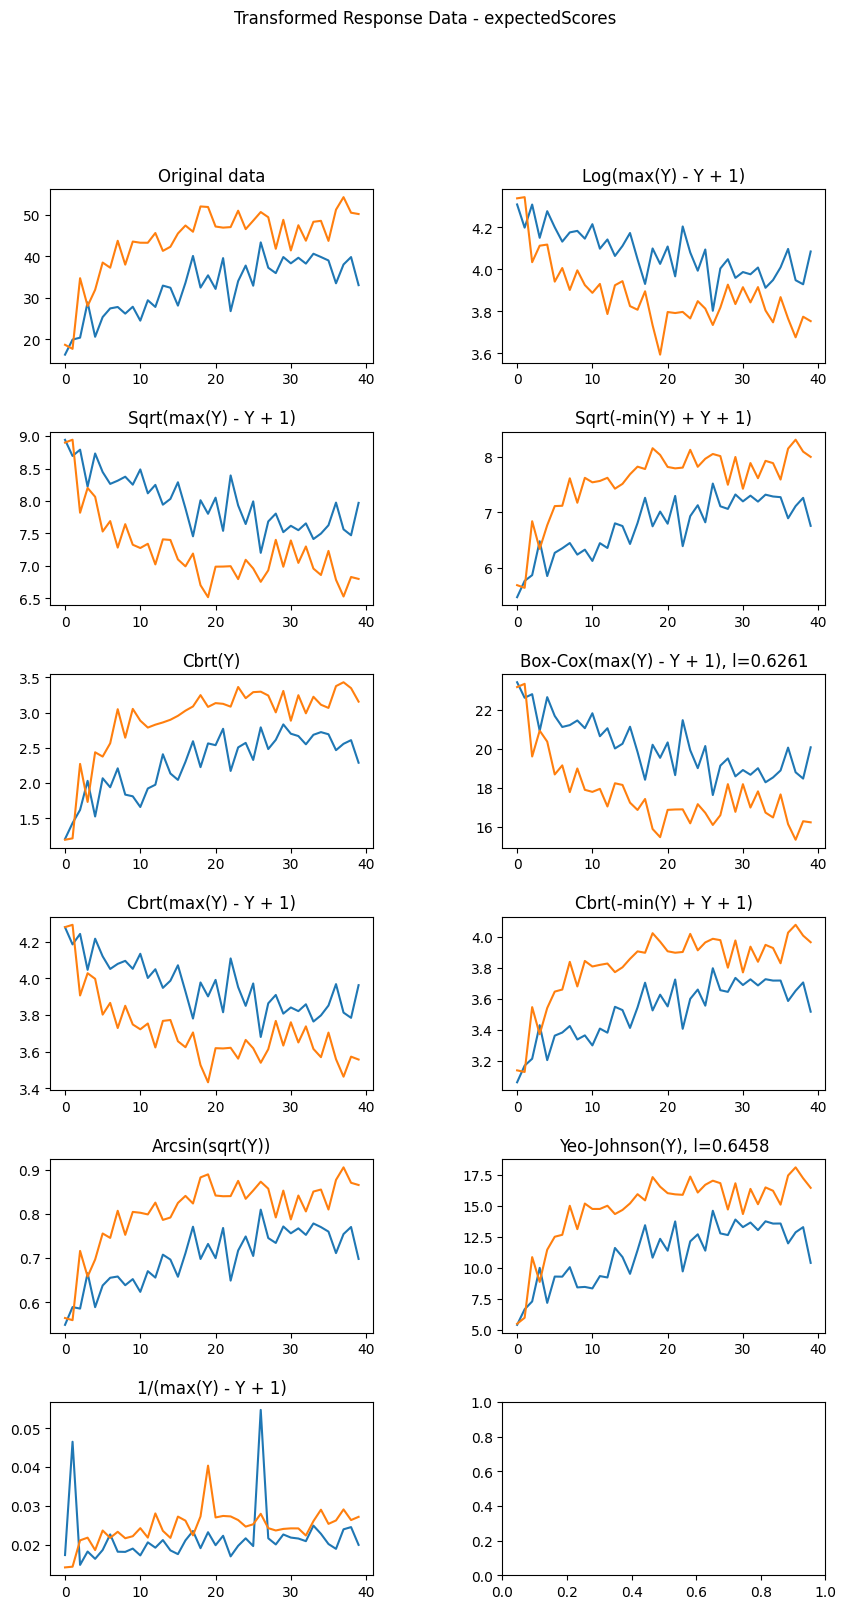

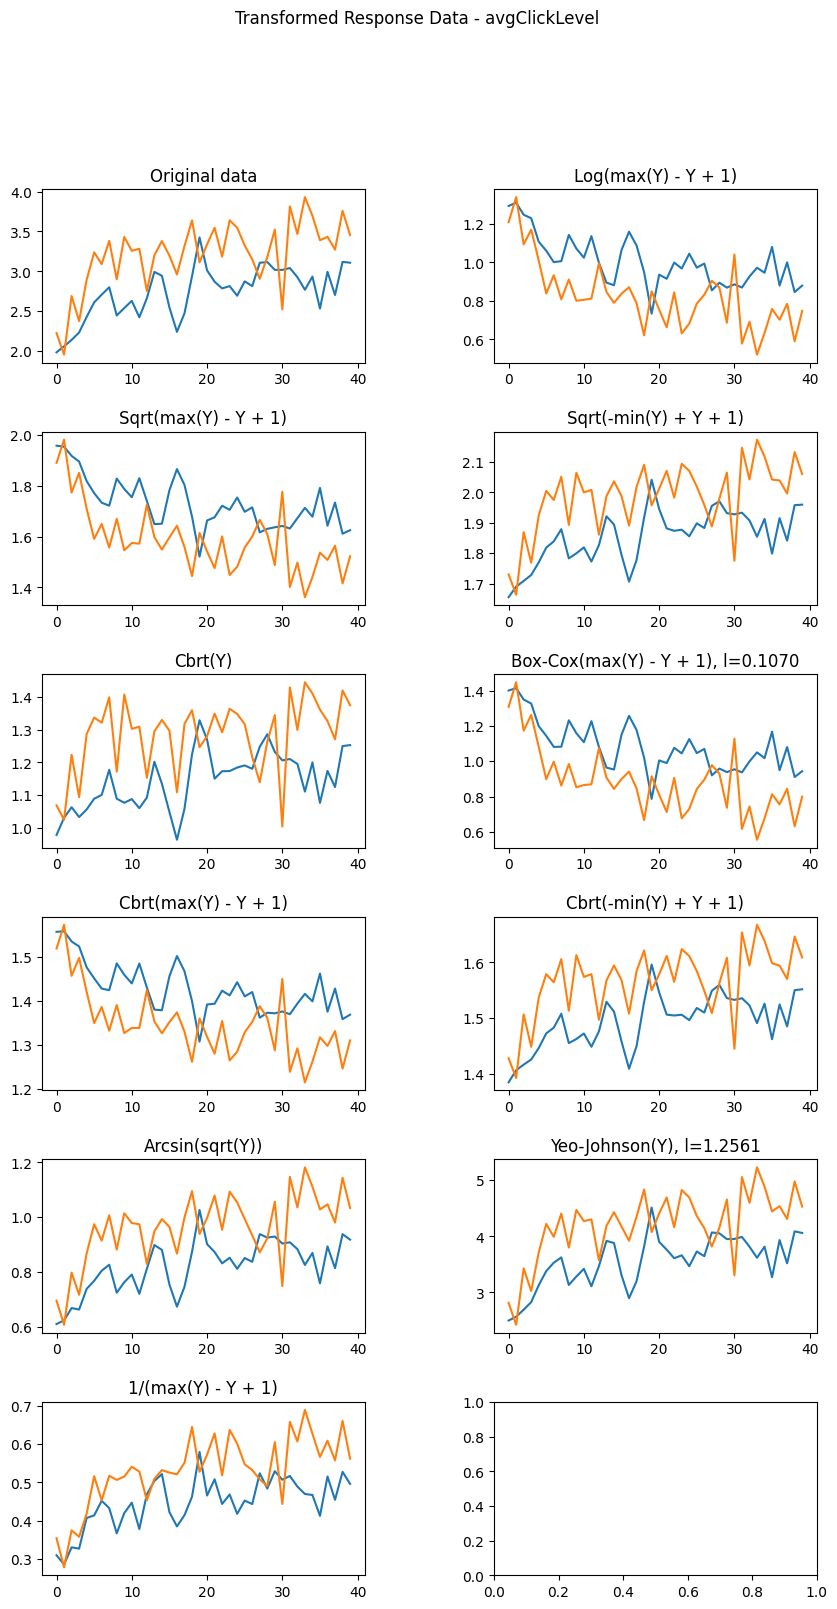

In [26]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Exp")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [332]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [27]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(condition)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   2240      Method:               REML          
No. Groups:         56        Scale:                485.7941      
Min. group size:    40        Log-Likelihood:       -10099.2374   
Max. group size:    40        Converged:            Yes           
Mean group size:    40.0                                          
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              23.602    4.928  4.790 0.000  13.944 33.260
C(trialNumbers)[T.2]    1.576    4.165  0.378 0.705  -6.588  9.740
C(trialNumbers)[T.3]    9.444    4.165  2.267 0.023   1.280 17.608
C(trialNumbers)[T.4]   11.161    4.165  2.679 0.007   2.997 19.325
C(trialNumbers)[T.5]    8.311    4.165  1.99

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               2.3967        
Min. group size:    40       Log-Likelihood:      -4263.0405    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              6.028    0.364 16.572 0.000  5.315  6.740
C(trialNumbers)[T.2]   0.141    0.293  0.482 0.630 -0.432  0.714
C(trialNumbers)[T.3]   0.734    0.293  2.509 0.012  0.161  1.307
C(trialNumbers)[T.4]   0.850    0.293  2.904 0.004  0.276  1.423
C(trialNumbers)[T.5]   0.693    0.293  2.367 0.018  0.119  1.266
C(trialNumbers)[T.6]   1.078    0.293  


expectedScores - Cbrt(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               0.2960        
Min. group size:    40       Log-Likelihood:      -1952.0307    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              4.140    0.112 37.064 0.000  3.921  4.359
C(trialNumbers)[T.2]  -0.046    0.103 -0.448 0.654 -0.248  0.155
C(trialNumbers)[T.3]  -0.186    0.103 -1.813 0.070 -0.388  0.015
C(trialNumbers)[T.4]  -0.241    0.103 -2.341 0.019 -0.442 -0.039
C(trialNumbers)[T.5]  -0.160    0.103 -1.559 0.119 -0.362  0.041


expectedScores - Yeo-Johnson(Y), l=0.6458:
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               52.3217       
Min. group size:    40       Log-Likelihood:      -7651.1141    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              7.484    1.657  4.517 0.000  4.237 10.731
C(trialNumbers)[T.2]   0.911    1.367  0.667 0.505 -1.768  3.591
C(trialNumbers)[T.3]   3.455    1.367  2.527 0.011  0.775  6.134
C(trialNumbers)[T.4]   4.065    1.367  2.974 0.003  1.386  6.744
C(trialNumbers)[T.5]   3.657    1.367  2.675 0.007  0.978  6

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               0.0011        
Min. group size:    40       Log-Likelihood:      4305.7755     
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.017    0.005  3.757 0.000  0.008  0.027
C(trialNumbers)[T.2]   0.016    0.006  2.653 0.008  0.004  0.028
C(trialNumbers)[T.3]   0.002    0.006  0.279 0.780 -0.010  0.014
C(trialNumbers)[T.4]   0.004    0.006  0.641 0.522 -0.008  0.016
C(trialNumbers)[T.5]   0.001    0.006  0.238 0.812 -0.011  0.013
C

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    2240     Method:              REML         
No. Groups:          56       Scale:               0.1340       
Min. group size:     40       Log-Likelihood:      -1092.7220   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.851    0.087 21.312 0.000  1.680  2.021
C(trialNumbers)[T.2]   0.038    0.069  0.556 0.578 -0.097  0.174
C(trialNumbers)[T.3]  -0.075    0.069 -1.078 0.281 -0.210  0.061
C(trialNumbers)[T.4]  -0.052    0.069 -0.758 0.448 -0.188  0.083
C(trialNumbers)[T.5]  -0.158    0.069 -2.281 0.023 -0.293 -0.022
C(trialNumbers)[T.6]  -0.237    0.069 -


avgClickLevel - Box-Cox(max(Y) - Y + 1), l=0.1070:
             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    2240     Method:              REML         
No. Groups:          56       Scale:               0.2636       
Min. group size:     40       Log-Likelihood:      -1832.7576   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.251    0.116 10.799 0.000  1.024  1.478
C(trialNumbers)[T.2]   0.070    0.097  0.718 0.473 -0.121  0.260
C(trialNumbers)[T.3]  -0.088    0.097 -0.910 0.363 -0.279  0.102
C(trialNumbers)[T.4]  -0.061    0.097 -0.631 0.528 -0.251  0.129
C(trialNumbers)[T.5]  -0.212    0.097 -2.189 0.029 -


avgClickLevel - Yeo-Johnson(Y), l=1.2561:
             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    2240     Method:              REML         
No. Groups:          56       Scale:               2.8592       
Min. group size:     40       Log-Likelihood:      -4460.3303   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              3.001    0.414  7.239 0.000  2.188  3.813
C(trialNumbers)[T.2]  -0.138    0.320 -0.431 0.667 -0.764  0.489
C(trialNumbers)[T.3]   0.381    0.320  1.194 0.233 -0.245  1.008
C(trialNumbers)[T.4]   0.276    0.320  0.864 0.388 -0.350  0.902
C(trialNumbers)[T.5]   0.749    0.320  2.345 0.019  0.123  1.

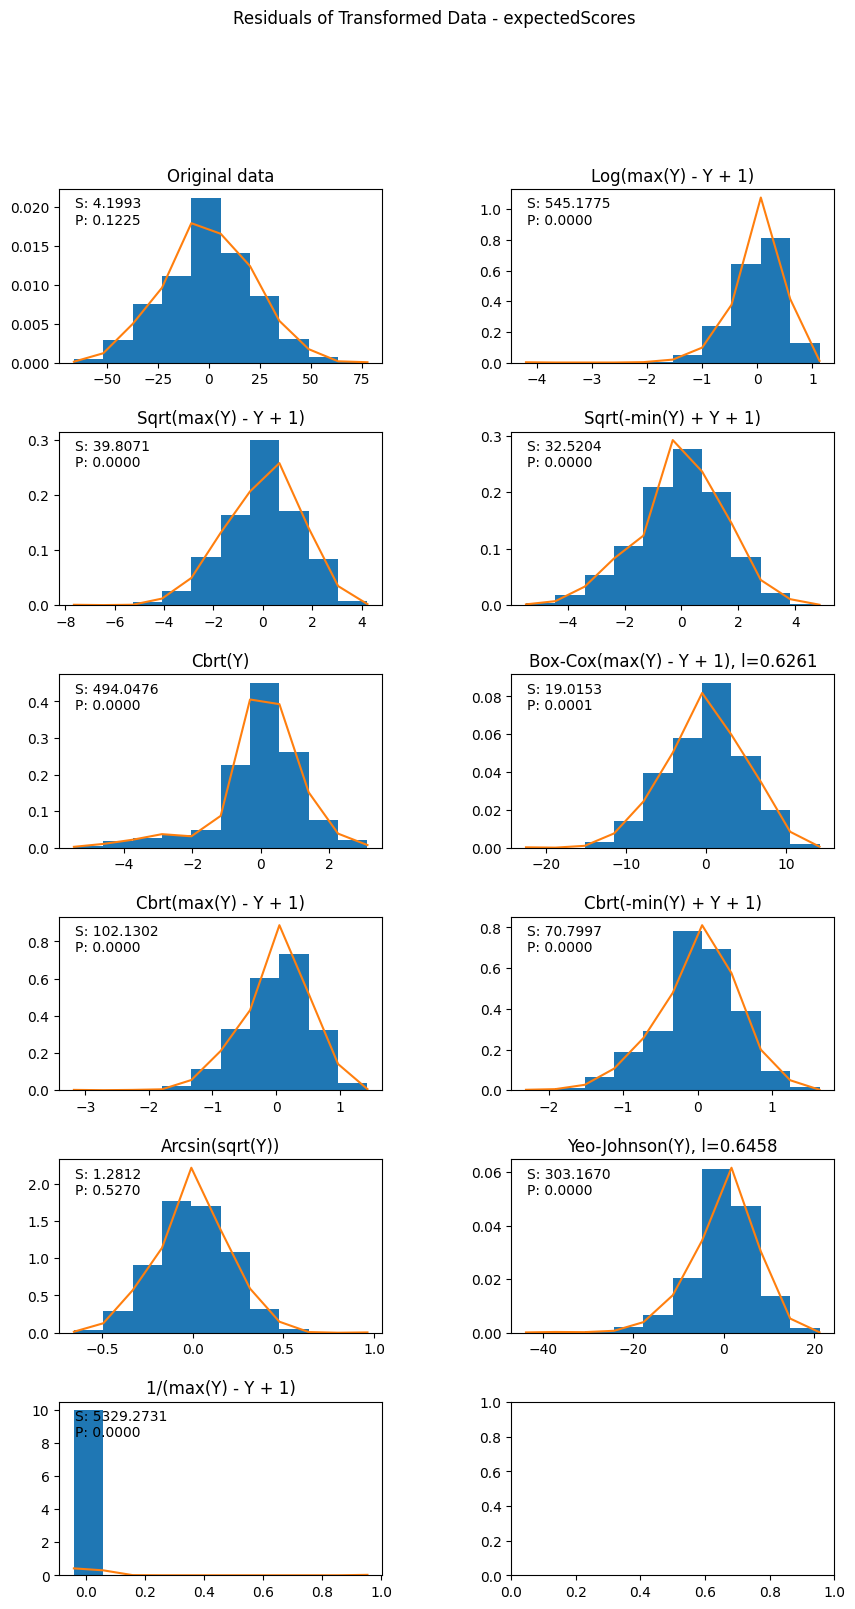

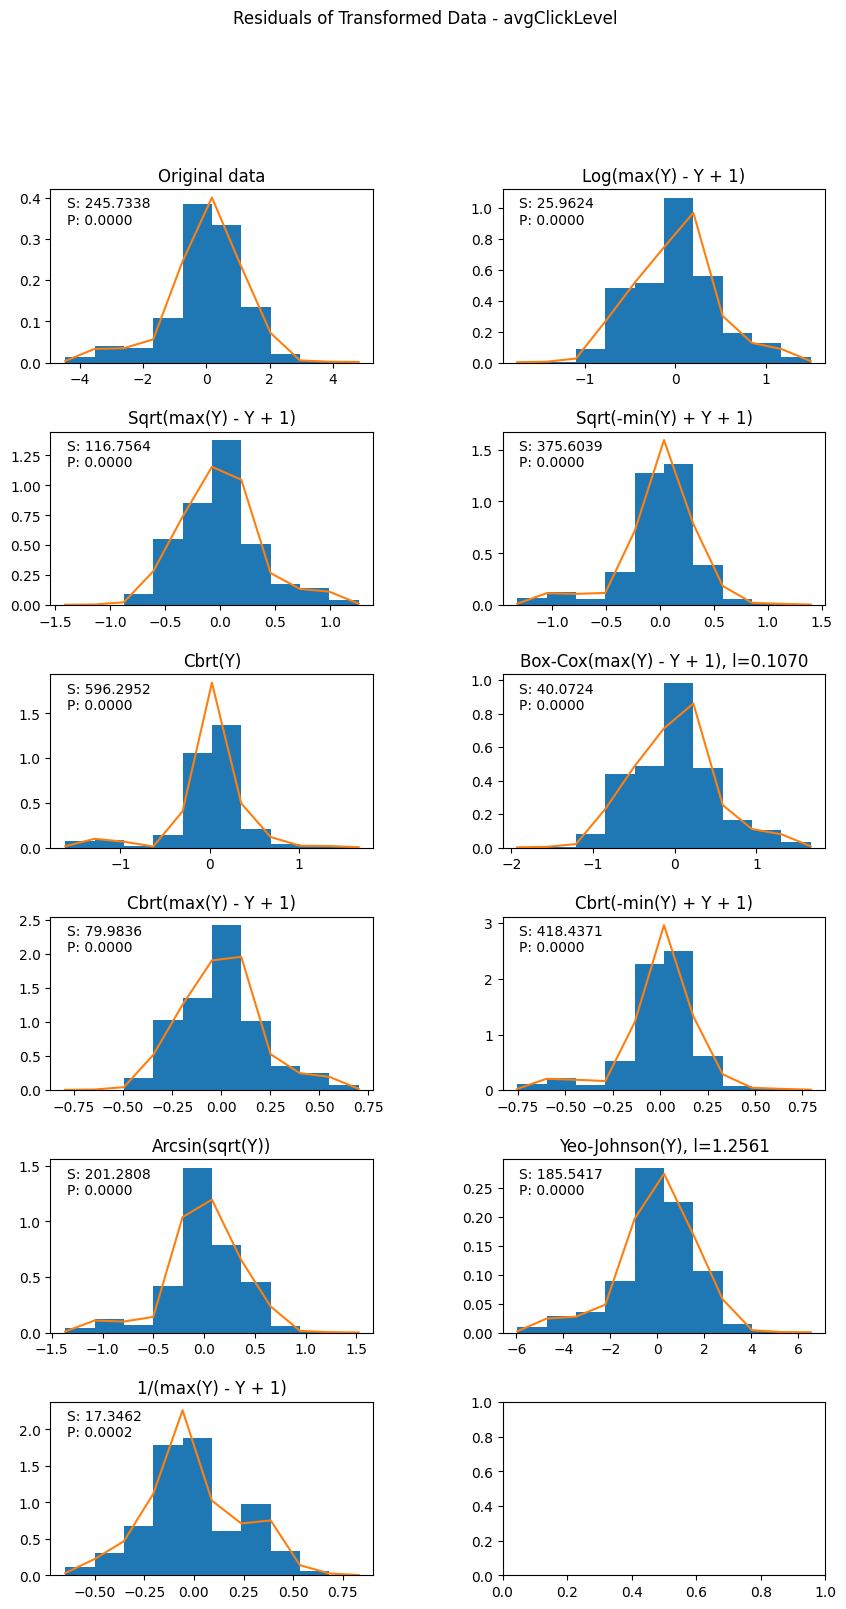

In [28]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [29]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Arcsin(sqrt(Y))
avgClickLevel - 1/(max(Y) - Y + 1)


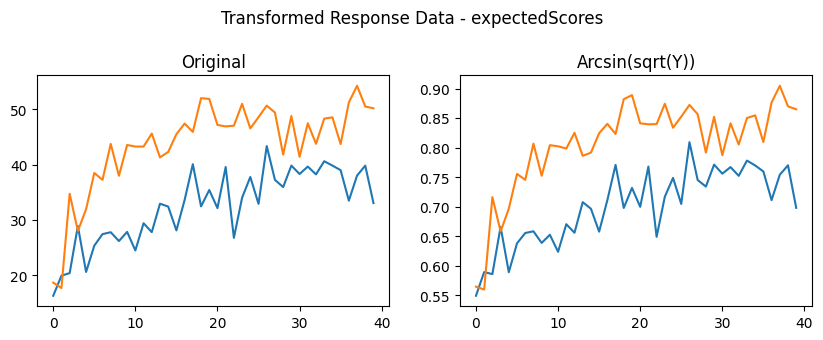

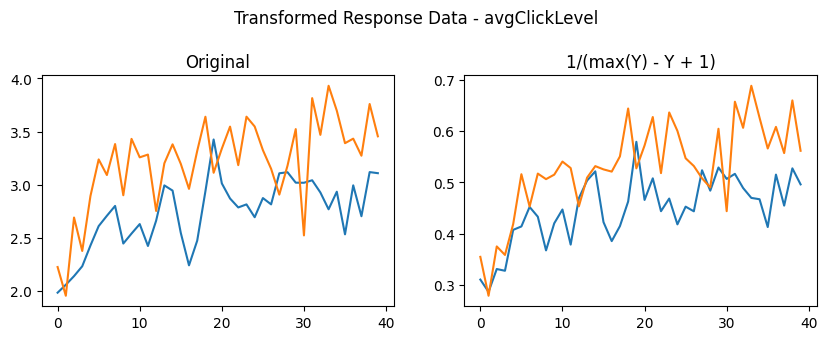

In [32]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

### Finding Best Model for Scarce Condition

In [38]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.condition == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores"]
    
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

In [39]:
# Finding the best partition of all significant ones 
if use_model_data:
    partition_candidates = [13] # Use partition from human dataset
else:
    sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_scarce[:,1]
        best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)



    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [40]:
# Showing GLM results - scarce
candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_scarce:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


NameError: name 'partition_candidates' is not defined

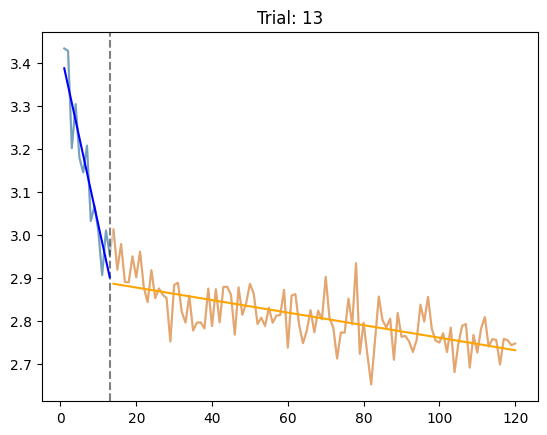

In [340]:
# Plotting candidate partitions - scarce
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False
error = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
        
    if error:
        plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [341]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [47]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.condition == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores"]
    
#     two_slope_formula = "expectedScores ~ trialNumbers + C(condition) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
#     one_slope_formula = "expectedScores ~ trialNumbers + C(condition)"
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [48]:
sig_bic_scores_control

[(2, 232.2992354570676),
 (3, 233.23060224132306),
 (4, 230.2028874669977),
 (5, 227.8621279798821),
 (6, 227.42476635647543),
 (7, 226.7927377106755),
 (8, 226.79499293848858),
 (9, 227.22791681726827),
 (10, 227.369667431884),
 (11, 227.79141878444673),
 (12, 228.4542590971575),
 (13, 228.7937981050473),
 (14, 230.04141567021694),
 (15, 230.8410181183952),
 (16, 231.16845612846987),
 (17, 231.41818969558798),
 (18, 232.05862023111416),
 (19, 231.6427762589435),
 (20, 230.81502227661935),
 (21, 232.0489343441702),
 (22, 233.39347022451338),
 (23, 234.7406346464397),
 (24, 234.44442058314718),
 (25, 236.3001172365479),
 (26, 237.07826695782134),
 (27, 236.50580301478357),
 (28, 236.66806847718843)]

Partition candidates: 
[7.]


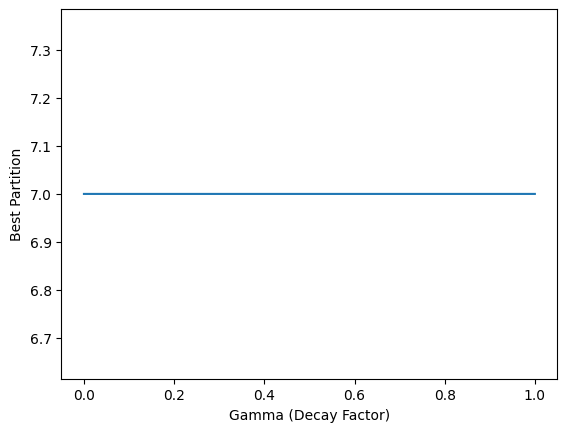

In [49]:
# Finding the best partition of all significant ones 

if use_model_data:
    partition_candidates = [9] # Use partition from human data
else:
    sig_bic_scores_control = np.array(sig_bic_scores_control)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_control[:,1]
        best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [345]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 6537.1924

BIC Deviance: -23313.7604

AIC: 6513.0487

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                 3090
Model:                            GLM   Df Residuals:                     3086
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.48124
Method:                          IRLS   Log-Likelihood:                -3252.5
Date:                Mon, 23 Jan 2023   Deviance:                       1485.1
Time:                        21:57:29   Pearson chi2:                 1.49e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04783
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
--------

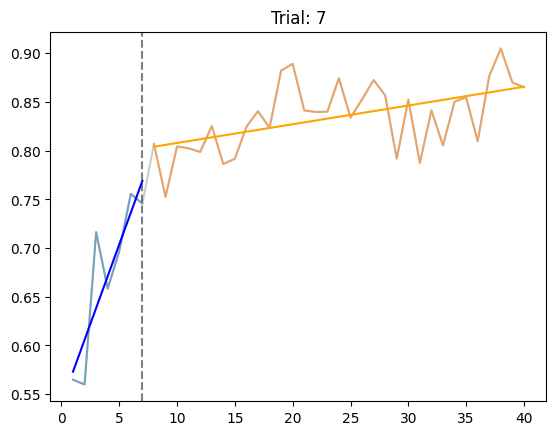

In [46]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [347]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

# 1.2 - Linear Regression: Response Var vs. Trial Number x Condition

In [348]:
# Select the response variable for this analysis

response_var = "expectedScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [349]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = True
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    expectedScores
No. Observations:      2292       Method:                REML          
No. Groups:            208        Scale:                 196.1879      
Min. group size:       9          Log-Likelihood:        -9559.1139    
Max. group size:       13         Converged:             Yes           
Mean group size:       11.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    14.345    1.720  8.341 0.000 10.974 17.716
C(scarce)[T.1]               -0.579    2.349 -0.247 0.805 -5.184  4.025
trialNumbers                  1.515    0.178  8.502 0.000  1.166  1.864
trialNumbers:C(scarce)[T.1]  -0.319    0.205 -1.557 0.119 -0.721  0.083
Group Var

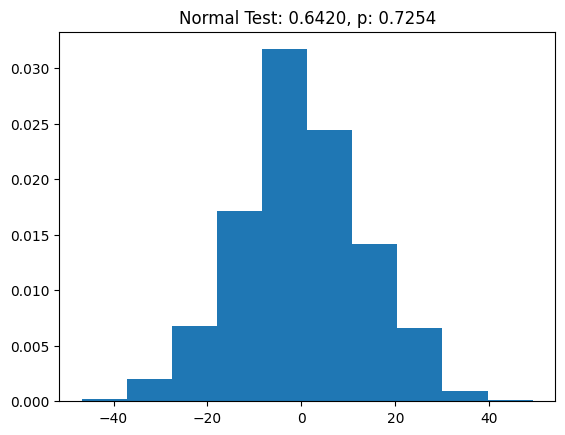

In [350]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Compare only the first 30 trials
if not compare_all:
    learning_df = learning_df.loc[learning_df.trialNumbers <= num_max_trials]

formula = '{} ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

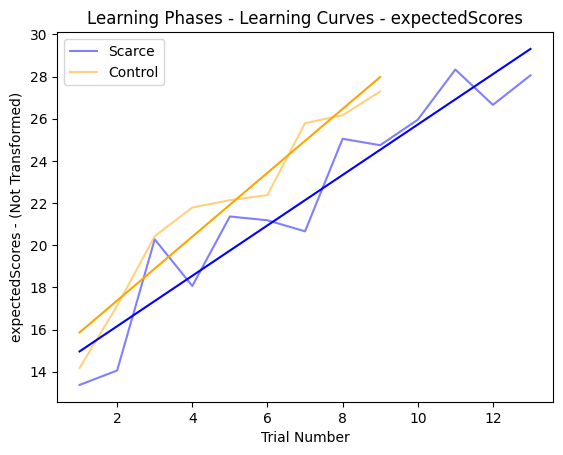

In [351]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.scarce==0].groupby("trialNumbers").mean()[response_var]
y2 = learning_df[learning_df.scarce==1].groupby("trialNumbers").mean()[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(scarce)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(scarce)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    expectedScores
No. Observations:      13398      Method:                REML          
No. Groups:            208        Scale:                 179.0571      
Min. group size:       21         Log-Likelihood:        -54161.9251   
Max. group size:       107        Converged:             Yes           
Mean group size:       64.4                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    25.931    1.606 16.148 0.000 22.783 29.078
C(scarce)[T.1]                3.058    2.057  1.486 0.137 -0.975  7.090
trialNumbers                  0.217    0.048  4.572 0.000  0.124  0.310
trialNumbers:C(scarce)[T.1]  -0.172    0.048 -3.609 0.000 -0.266 -0.079
Group Var

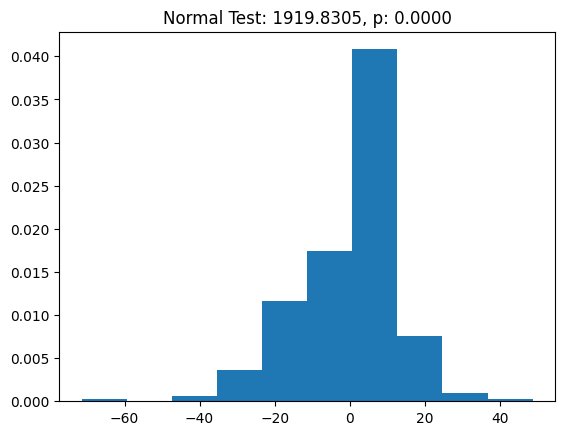

In [352]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

if not compare_all:
    performance_df = performance_df.loc[performance_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

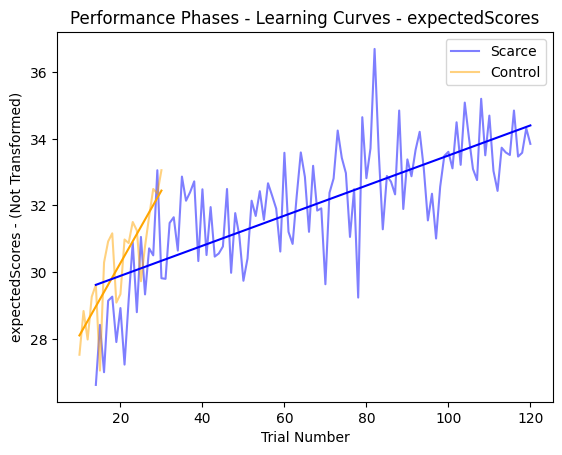

In [353]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.scarce==0].groupby("trialNumbers").mean()[response_var]
y2 = performance_df[performance_df.scarce==1].groupby("trialNumbers").mean()[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(scarce)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(scarce)[T.1]']

if not compare_all:
    end_index = np.where(x1 == num_max_trials)[0]
    if len(end_index) > 0:
        end_index = end_index[0]
        x1 = x1[0:end_index]
        y1 = y1[0:end_index]
    
    end_index = np.where(x2 == num_max_trials)[0]
    if len(end_index) > 0:
        end_index = end_index[0]
        x2 = x2[0:end_index]
        y2 = y2[0:end_index]
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 1.3 - Linear Regression: Response Var vs. Num Rewarded Trials

GLM Analysis for the effect of number of previously rewarded trials and previously unrewarded trials on improvement in response variable in each condition

(response_var) ~ numRewardedTrials + numUnrewardedTrials + condition + numRewardedTrials x condition

In [354]:
# Select the response variable for this analysis

response_var = "expectedScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [355]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = True
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      expectedScores
No. Observations:       2292         Method:                  REML          
No. Groups:             208          Scale:                   196.2527      
Min. group size:        9            Log-Likelihood:          -9558.6164    
Max. group size:        13           Converged:               Yes           
Mean group size:        11.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         15.860    1.635  9.697 0.000 12.654 19.065
C(scarce)[T.1]                    -0.900    2.260 -0.398 0.690 -5.329  3.528
numRewardedTrials                  1.515    0.178  8.501 0.000  1.166  1.864
numRewardedTrials:C

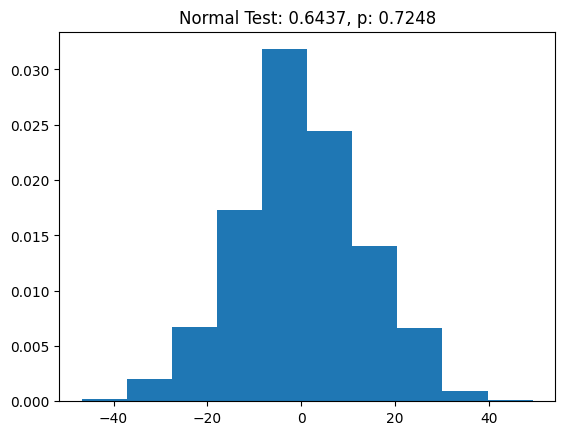

In [356]:
# Learning Phase 

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

if not compare_all:
    learning_df = learning_df.loc[learning_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results_learning = glm.fit()

print(results_learning.summary())
resids = results_learning.resid_response if not mixed else results_learning.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [357]:
# comparing coefficients using contrasts

# between conditions
# H_a = numRewardedTrials - numUnrewardedTrials > 0
print("H_a = numRewardedTrials - numUnrewardedTrials > 0")
r = np.zeros_like(results_learning.params)
r[list(results_learning.params.index).index("numRewardedTrials")] = 1
r[list(results_learning.params.index).index("numUnrewardedTrials")] = -1

print(results_learning.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_learning.f_test(r))
print(results_learning.wald_test(r))

# within scarce condition
# H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
print("\nH_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0")
r = np.zeros_like(results_learning.params)
r[list(results_learning.params.index).index("numRewardedTrials")] = 1
r[list(results_learning.params.index).index("numRewardedTrials:C(scarce)[T.1]")] = 1
r[list(results_learning.params.index).index("numUnrewardedTrials")] = -1
print(results_learning.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_learning.f_test(r))
print(results_learning.wald_test(r))

H_a = numRewardedTrials - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3720      0.267      1.394      0.163      -0.151       0.895
<F test: F=1.9420102993112585, p=0.16358583037821883, df_denom=2.29e+03, df_num=1>
<Wald test (chi2): statistic=[[1.9420103]], p-value=0.16345042510437524, df_denom=1>

H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1935      0.626      0.309      0.757      -1.033       1.420
<F test: F=0.0956128718063366, p=0.7571874359614779, df_denom=2.2

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      expectedScores
No. Observations:       13398        Method:                  REML          
No. Groups:             208          Scale:                   178.9682      
Min. group size:        21           Log-Likelihood:          -54159.2324   
Max. group size:        107          Converged:               Yes           
Mean group size:        64.4                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         26.148    1.578 16.570 0.000 23.055 29.241
C(scarce)[T.1]                     2.578    2.038  1.265 0.206 -1.417  6.572
numRewardedTrials                  0.217    0.048  4.573 0.000  0.124  0.310
numRewardedTrials:C

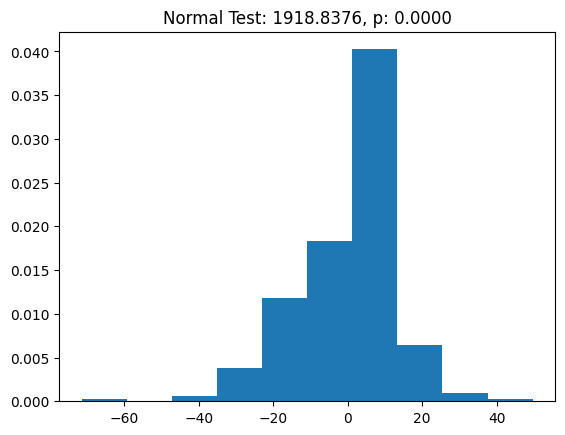

In [358]:
# Performance phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

if not compare_all:
    performance_df = performance_df.loc[performance_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results_performance = glm.fit()

print(results_performance.summary())
resids = results_performance.resid_response if not mixed else results_performance.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [360]:
# comparing coefficients using contrasts

# between conditions
# H_a = numRewardedTrials - numUnrewardedTrials > 0
print("H_a = numRewardedTrials - numUnrewardedTrials > 0")
r = np.zeros_like(results_performance.params)
r[list(results_performance.params.index).index("numRewardedTrials")] = 1
r[list(results_performance.params.index).index("numUnrewardedTrials")] = -1

print(results_performance.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_performance.f_test(r))
print(results_performance.wald_test(r))

# within scarce condition
# H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
print("\nH_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0")
r = np.zeros_like(results_performance.params)
r[list(results_performance.params.index).index("numRewardedTrials")] = 1
r[list(results_performance.params.index).index("numRewardedTrials:C(scarce)[T.1]")] = 1
r[list(results_performance.params.index).index("numUnrewardedTrials")] = -1
print(results_performance.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_performance.f_test(r))
print(results_performance.wald_test(r))

H_a = numRewardedTrials - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2623      0.058      4.535      0.000       0.149       0.376
<F test: F=20.56548474127082, p=5.812583967519808e-06, df_denom=1.34e+04, df_num=1>
<Wald test (chi2): statistic=[[20.56548474]], p-value=5.762576472694613e-06, df_denom=1>

H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3662      0.133      2.754      0.006       0.106       0.627
<F test: F=7.5846043727801495, p=0.005894828740316612, df_de

# 1.4 - Independent Samples T-test

In [361]:
# Select the response variable for this analysis

response_var = "expectedScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [362]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = False
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

In [363]:
use_transformed = False

if not compare_all:
    control_performance_data = control_performance_data.loc[control_performance_data.trialNumbers <= num_max_trials]
    scarce_performance_data = scarce_performance_data.loc[scarce_performance_data.trialNumbers <= num_max_trials]

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean()
    scarce_averages = scarce_performance_data.groupby('workerId').mean()
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean()
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean()
    

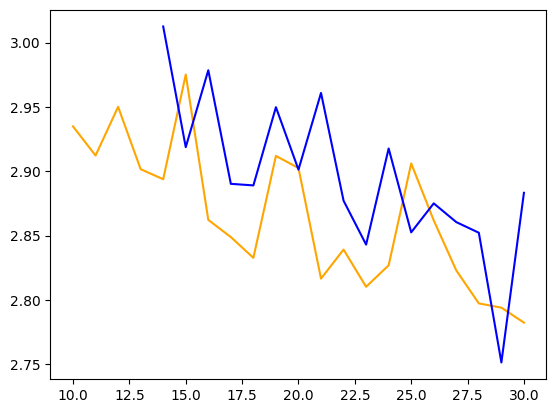

In [364]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean()[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean()[response_var], color='b')
plt.show()

30.275080906148865 13.652829629137571
32.01023587004896 12.376307354792148


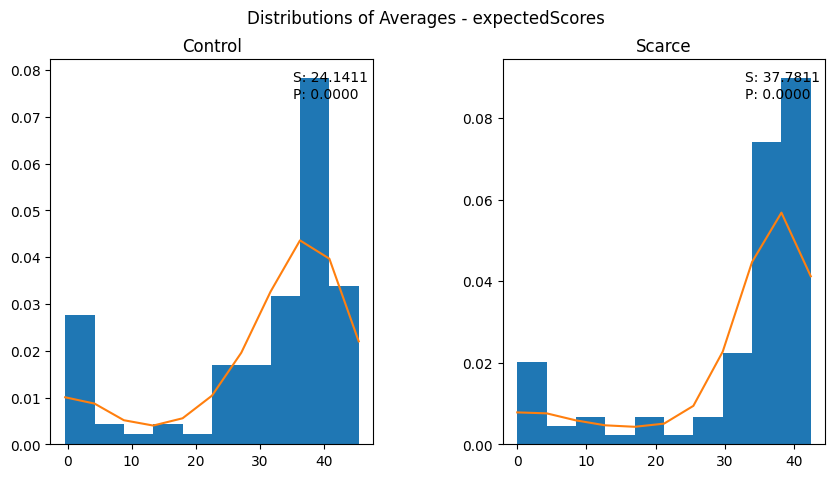

In [365]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Scarce")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [245]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores
Two-Sided:
	Statistic: 0.648
	P-value: 0.5175054588183226
Scarce < Control:
	Statistic: 0.648
	P-value: 0.7412472705908386
Scarce > Control:
	Statistic: 0.648
	P-value: 0.2587527294091613


In [246]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 5230.000
	P-value: 0.6615315144733205
Scarce < Control:
	Statistic: 5230.000
	P-value: 0.6701129758904127
Scarce > Control:
	Statistic: 5230.000
	P-value: 0.33076575723666024


# 1.6 - Stable Strategy Comparisons

Analysis to see which of the strategies participants converged on and whether they are the same in both conditions

In [213]:
filtered_data['strategy'] = filtered_data['strategy'].astype('int64')

In [214]:
# Strategies taken are from the latter 50% of the trials of each participant

# Take median of participant strategies or mode (most frequent)
measure = 'median' #median, mode

if measure == 'median':
    scarce_end_strat = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers > 60)].groupby('workerId').median()['strategy'].astype('int64')
    control_end_strat = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > 15)].groupby('workerId').median()['strategy'].astype('int64')
elif measure == 'mode':
    scarce_end_strat = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers > 60)].groupby('workerId')['strategy'].agg(pd.Series.mode)#.astype('int64')
    control_end_strat = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > 15)].groupby('workerId')['strategy'].agg(pd.Series.mode)#.astype('int64')

In [215]:
# Create contingency table

table = np.zeros((89,2))

for strat in scarce_end_strat:
    #print(type(strat))
    if type(strat) != int and type(strat) != np.int64:
        strat = strat[0]
    table[strat][1] += 1
    
for strat in control_end_strat:
    if type(strat) != int and type(strat) != np.int64:
        strat = strat[0]
    table[strat][0] += 1
    
table

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 2.,  1.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 0.,  1.],
       [ 0.,  4.],
       [ 0.,  0.],
       [ 0.,  0.],
       [48., 34.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 5.,  8.],
       [ 4.,  3.],
       [ 2.,  1.],
       [ 0.,  0.],
       [ 7.,  7.],
       [ 8.,  5.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 3.,  2.],
       [ 0.,  0.],
       [ 1.,  4.],
       [ 1.,  3.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  4.],
       [ 0.,  0.],
       [ 0.,

In [216]:
# Perform chi square test of independence

summed_tab = table.sum(axis=1)
nz_rows = np.where(summed_tab != 0)[0]
new_table = table[nz_rows]



crosstab = pd.crosstab(new_table[:,0], new_table[:,1])
scipy.stats.chi2_contingency(new_table)


(37.14788229067282,
 0.2437497664233364,
 32,
 array([[ 0.49253731,  0.50746269],
        [ 1.47761194,  1.52238806],
        [ 0.49253731,  0.50746269],
        [ 0.98507463,  1.01492537],
        [ 0.49253731,  0.50746269],
        [ 1.97014925,  2.02985075],
        [40.3880597 , 41.6119403 ],
        [ 0.49253731,  0.50746269],
        [ 0.49253731,  0.50746269],
        [ 6.40298507,  6.59701493],
        [ 3.44776119,  3.55223881],
        [ 1.47761194,  1.52238806],
        [ 6.89552239,  7.10447761],
        [ 6.40298507,  6.59701493],
        [ 0.49253731,  0.50746269],
        [ 0.49253731,  0.50746269],
        [ 2.46268657,  2.53731343],
        [ 2.46268657,  2.53731343],
        [ 1.97014925,  2.02985075],
        [ 0.49253731,  0.50746269],
        [ 0.98507463,  1.01492537],
        [ 2.46268657,  2.53731343],
        [ 2.95522388,  3.04477612],
        [ 0.49253731,  0.50746269],
        [ 1.97014925,  2.02985075],
        [ 2.46268657,  2.53731343],
        [ 0.492537

# Appendix

### Visualization of Distributions of Exclusion Criteria Statistics

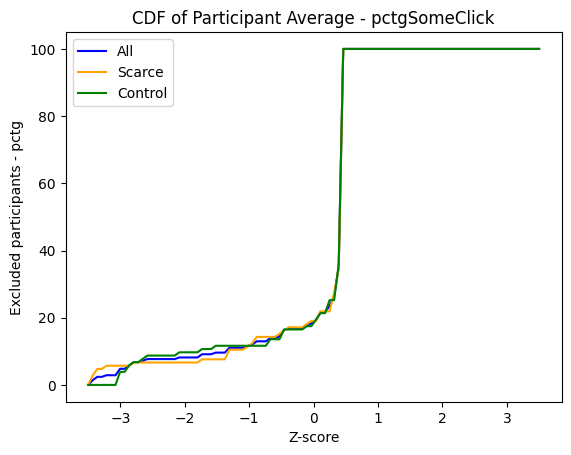

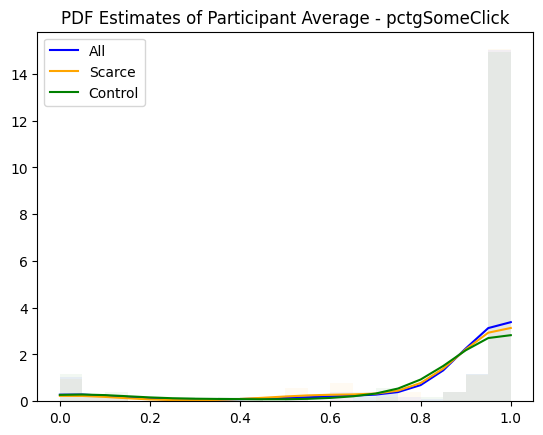

In [14]:
# Sensitivity analysis of zscore threshold for exclusion


exclusion_criteria = "pctgSomeClick" # column of all_part_averages
z_threshs = np.linspace(-3.5, 3.5, 100);

excluded = {
    "scarce": {
        "abs": [],
        "pctg": []
    },
    "control": {
        "abs": [],
        "pctg": []
    },
    "all": {
        "abs": [],
        "pctg": []
    }
    
}
for thresh in z_threshs:
    excluded_parts_control = control_part_averages[scipy.stats.zscore(control_part_averages[exclusion_criteria]) < thresh]
    included_parts_control = control_part_averages[scipy.stats.zscore(control_part_averages[exclusion_criteria]) >= thresh]

    excluded_parts_scarce = scarce_part_averages[scipy.stats.zscore(scarce_part_averages[exclusion_criteria]) < thresh]
    included_parts_scarce = scarce_part_averages[scipy.stats.zscore(scarce_part_averages[exclusion_criteria]) >= thresh]

    num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

    excluded["all"]["abs"].append(num_excluded_parts)
    excluded["all"]["pctg"].append(100 * num_excluded_parts / len(all_trials_df.groupby("workerId")))
    
    excluded["control"]["abs"].append(len(excluded_parts_control))
    excluded["control"]["pctg"].append(100 * len(excluded_parts_control) / len(control_part_averages))
                                     
    excluded["scarce"]["abs"].append(len(excluded_parts_scarce))
    excluded["scarce"]["pctg"].append(100 * len(excluded_parts_scarce) / len(scarce_part_averages))

which_plot = "pctg" #abs, pctg
plt.title("CDF of Participant Average - {}".format(exclusion_criteria))
plt.plot(z_threshs, excluded["all"][which_plot], label = "All",color='b')
plt.plot(z_threshs, excluded["scarce"][which_plot], label = "Scarce", color='orange')
plt.plot(z_threshs, excluded["control"][which_plot], label = "Control", color='g')
plt.xlabel("Z-score")
plt.ylabel("Excluded participants - {}".format(which_plot))
plt.legend()

plt.figure()
binwidth = 0.05
data = all_part_averages[exclusion_criteria]
plt.title("PDF Estimates of Participant Average - {}".format(exclusion_criteria))
density_all = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='b', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_all(x), label="All", color='b')

data = scarce_part_averages[exclusion_criteria]                   
density_s = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='orange', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_s(x), label="Scarce", color='orange')

data = control_part_averages[exclusion_criteria]      
density_c = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='g', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_c(x), label="Control", color='g')

plt.legend()
                                                                       
plt.show()

In [15]:
# Select the exclusion criteria

selected_exclusion_col = "pctgSomeClick"

In [54]:
# Cross-checking adaptiveness of strategies

adaptive_strats = [65, 64, 24, 21, 63, 43,
    17, 16, 57, 59, 88, 54,
    4, 31, 26, 82, 37, 48,
    50, 85, 76, 18, 84, 45,
    11, 6, 7, 29, 80, 36, 67,
    12, 87, 60, 5, 10, 49,
    42, 72, 51, 2, 71, 13,
    40, 14, 15, 78, 56]

m_adaptive_strats = [33, 44, 27, 79, 69,
34, 61, 73, 32]

maladaptive_strats = [22, 53, 39, 28, 30,
23, 66, 70, 74]

for idx, (strat_list, label) in enumerate(zip([adaptive_strats, m_adaptive_strats, maladaptive_strats], ["Adaptive", "Moderate", "Maladaptive"])):
    print("\n" + label)
    for strat in strat_list:
        print(strat, scarce_cluster_dict[strat-1] == idx, control_cluster_dict[strat-1] == idx)
    


Adaptive
65 True True
64 True True
24 True True
21 True True
63 True True
43 True True
17 True True
16 True True
57 True True
59 True True
88 True True
54 True True
4 True True
31 True True
26 True True
82 True True
37 True True
48 True True
50 True True
85 True True
76 True True
18 True True
84 True True
45 True True
11 True True
6 True True
7 True True
29 True True
80 True True
36 True True
67 True True
12 True True
87 True True
60 True True
5 True True
10 True True
49 True True
42 True True
72 True True
51 True True
2 True True
71 True True
13 True True
40 True True
14 True True
15 True True
78 True True
56 True True

Moderate
33 True True
44 True True
27 True True
79 True True
69 True True
34 True True
61 True True
73 True True
32 True True

Maladaptive
22 True True
53 True True
39 True True
28 True True
30 True True
23 True True
66 True True
70 True True
74 True True


In [348]:
# Plotting single model fit vs participant data

pid = "60e88e2e4236b6f23a6d702d"
condition = "control"
model_num = "0.2"

if condition == "original":
    df = r_data_df
else:
    df = filtered_data
    
expected = False
if expected:
    df_column = "expectedScores"
    column = 'mer'
else:
    df_column = "trialScores"
    column = 'r'

single_part = df.loc[df.workerId == pid]
doc = collection.find_one({ "condition": condition, "model": model_num, "pid": pid})
rewards = doc[column]
avg_rewards = np.array(rewards).mean(axis=0)
sd_rewards = np.array(rewards).std(axis=0)
plt.plot(range(len(single_part[df_column])), single_part[df_column].astype(int),label="participant",color='orange')
plt.plot(range(len(avg_rewards)), avg_rewards,label="model",color='blue')
plt.fill_between(list(range(len(avg_rewards))), avg_rewards + sd_rewards, avg_rewards - sd_rewards, alpha=0.1,color='blue')
plt.title(f"{pid}")
plt.xlabel("Trial Num")
plt.ylabel("Score")
plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

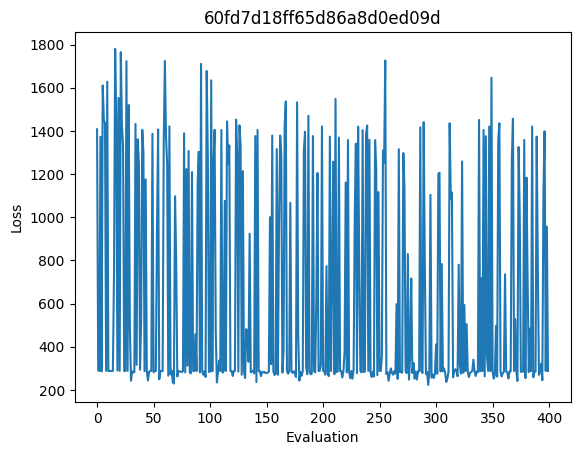

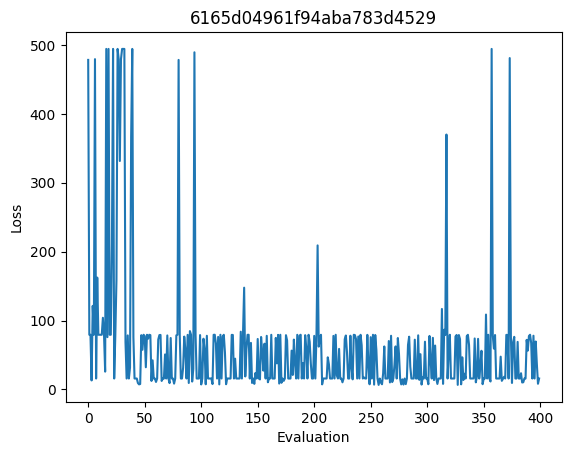

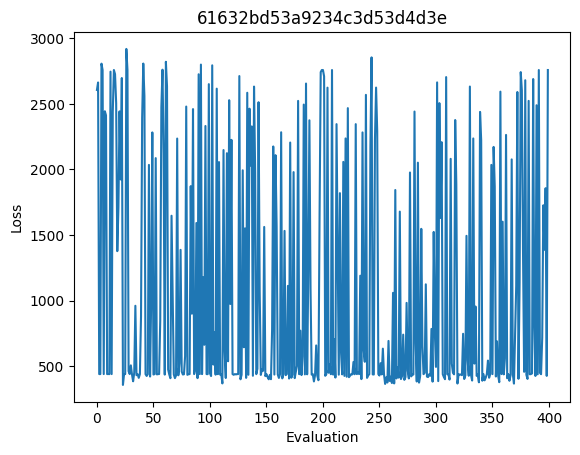

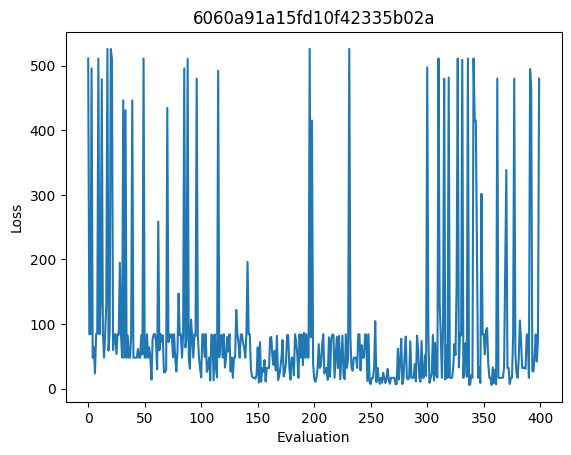

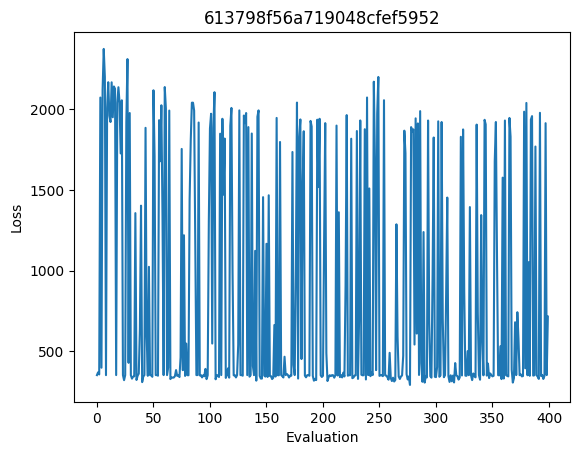

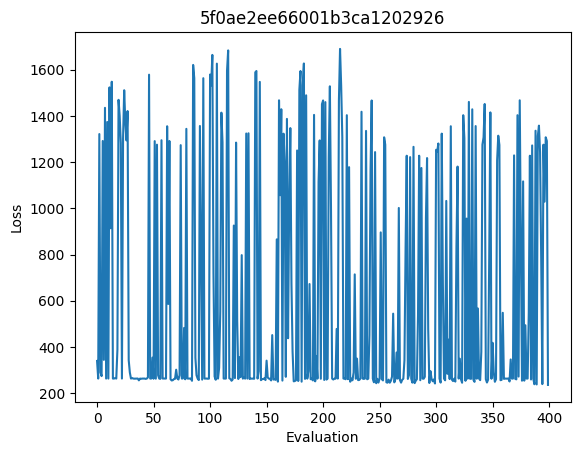

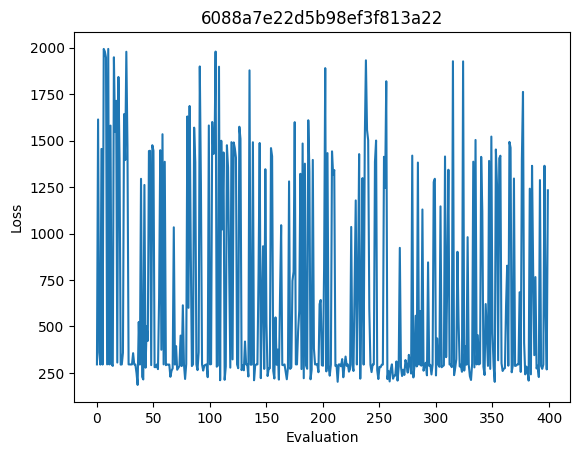

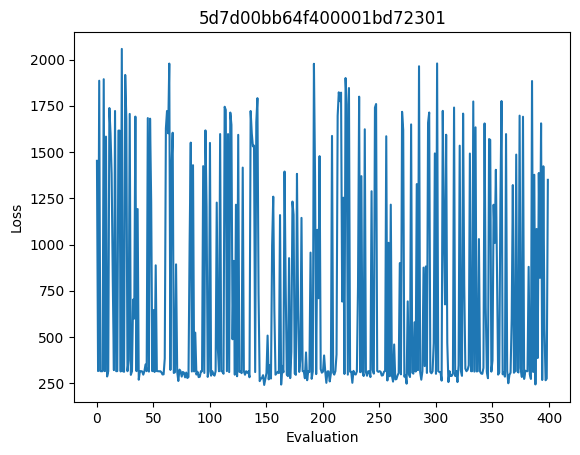

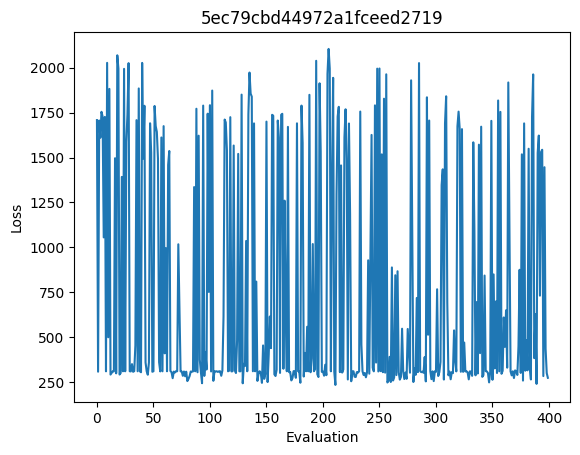

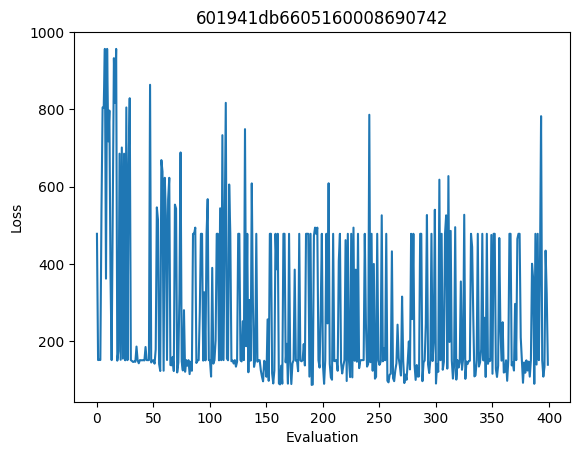

In [218]:
# Observing losses of model - vanilla LVOC

pid = "6115fcb4fcbab96f3ceb1734"
condition = "control"
model_num = "0.0.1"

doc = collection.find_one({ "condition": condition, "model": model_num, "pid": pid})

docs = collection.find({ "condition": "control", "model": "0.1"})

how_many_plot = 10
plotted = 0

for doc in docs:
    losses = doc["all_losses"]
    plt.figure(plotted)
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Evaluation")
    plt.ylabel("Loss")
    plt.title(doc["pid"])
    
    plotted += 1
    if plotted == how_many_plot:
        break
        
plt.show()

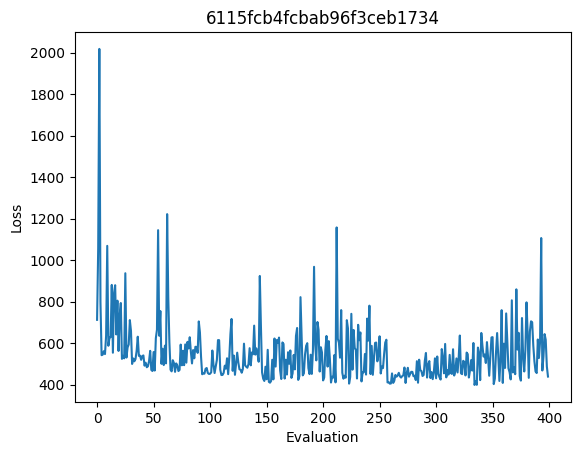

In [340]:
# Observing losses of model - vanilla LVOC

pid = "6115fcb4fcbab96f3ceb1734"
condition = "control"
model_num = "0.0.1"

doc = collection.find_one({ "condition": condition, "model": model_num, "pid": pid})


losses = doc["all_losses"]
plt.figure(plotted)
plt.plot(range(len(losses)), losses)
plt.xlabel("Evaluation")
plt.ylabel("Loss")
plt.title(doc["pid"])

        
plt.show()

# 1.5 - GLM Strategy Proportions

Observing how the strategies of the participants (as inferred by the Computational Microscope) change over time in each condition

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/2031249079.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


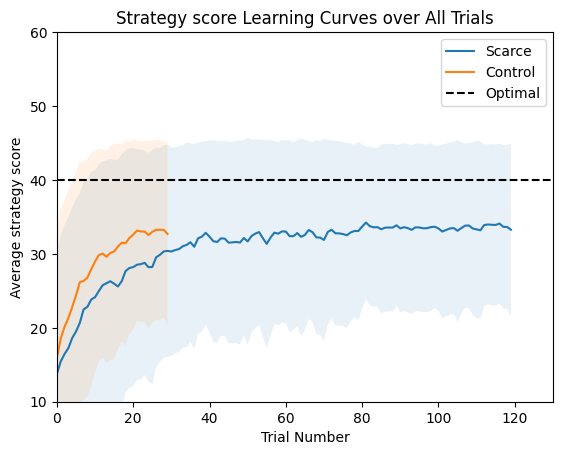

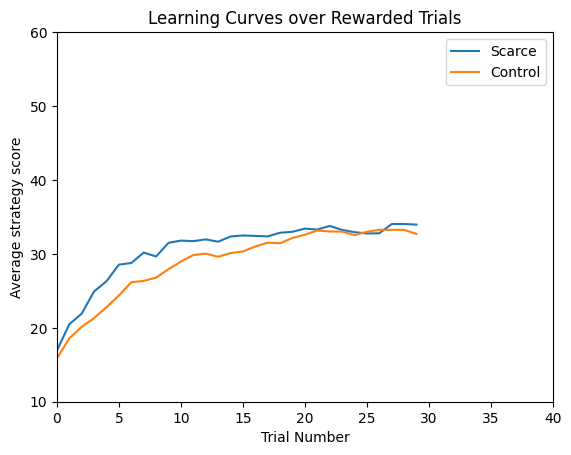

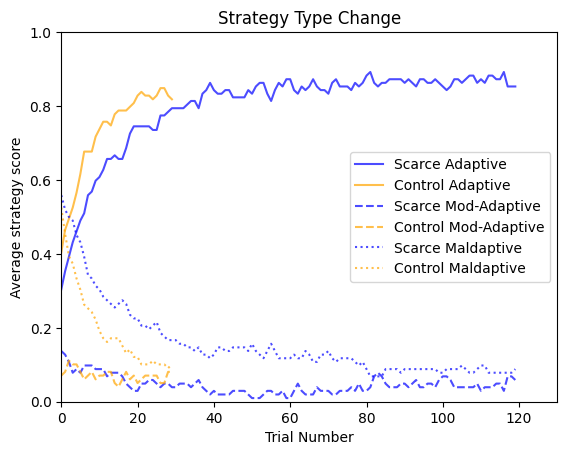

In [127]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean()["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std()["strategyScores"])
control_data = np.array(control_trial_group.mean()["strategyScores"])
control_data_sd = np.array(control_trial_group.std()["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())


# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

# Converting all to respective datatype
rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["strategyScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["strategyScores"])

plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0

## Removing Outliers

In [8]:
# Group statistics by participant
all_part_groups = all_trials_df.groupby('workerId')
control_part_groups = all_trials_df.loc[all_trials_df.scarce==0].groupby("workerId")
scarce_part_groups = all_trials_df.loc[all_trials_df.scarce==1].groupby("workerId")

# Get the averages of each statistic by participant
control_part_averages = control_part_groups.mean()
scarce_part_averages = scarce_part_groups.mean()
all_part_averages = all_part_groups.mean()

# Compute the proportion of trials with no clicks
all_part_averages['pctgSomeClick'] = (all_part_groups.apply(lambda x: x[x > 0].count()) / all_part_groups.count())['numClicks']
scarce_part_averages['pctgSomeClick'] = (scarce_part_groups.apply(lambda x: x[x > 0].count()) / scarce_part_groups.count())['numClicks']
control_part_averages['pctgSomeClick'] = (control_part_groups.apply(lambda x: x[x > 0].count()) / control_part_groups.count())['numClicks']

AttributeError: 'DataFrame' object has no attribute 'scarce'

### Removing Based on Selected Criteria

In [146]:
selected_exclusion_col = 'pctgSomeClick'

In [147]:
# Removing outliers 

# Excluding those that have 100% of their trials with no clicks


zscore_threshold = (0.0 - all_part_averages[selected_exclusion_col].mean()) / all_part_averages[selected_exclusion_col].std()
excluded_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] == 0]
included_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] > 0]

zscore_threshold = (0.0 - scarce_part_averages[selected_exclusion_col].mean()) / scarce_part_averages[selected_exclusion_col].std()
excluded_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] == 0]
included_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] > 0]

num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

print("Number of participants excluded: {0} ({1:0.2f}%)".format(
    num_excluded_parts,
    100 * num_excluded_parts /len(all_trials_df.groupby("workerId"))
))
print("\tControl: {0} ({1:0.2f}%)".format(
    len(excluded_parts_control),
    100 * len(excluded_parts_control) / len(control_part_averages)
))
print("\tScarce: {0} ({1:0.2f}%)".format(
    len(excluded_parts_scarce),
    100 * len(excluded_parts_scarce) / len(scarce_part_averages)
))
included_part_IDs = list(included_parts_scarce.index) + list(included_parts_control.index)
outliers_excluded_part = all_trials_df.loc[all_trials_df.workerId.isin(included_part_IDs)].reset_index(drop=True)
outliers_excluded_part['trialNumbers'] = outliers_excluded_part['trialNumbers'].astype('int64')
outliers_excluded_part['scarce'] = outliers_excluded_part['scarce'].astype('int64')
outliers_excluded_part['numRewardedTrials'] = outliers_excluded_part['numRewardedTrials'].astype('int64')
outliers_excluded_part['numUnrewardedTrials'] = outliers_excluded_part['numUnrewardedTrials'].astype('int64')


print("Number of total trials excluded: {0} ({1:0.2f}%)".format(len(all_trials_df)-len(outliers_excluded_part), 100-100*len(outliers_excluded_part)/(len(all_trials_df))))


Number of participants excluded: 7 (3.37%)
	Control: 4 (3.88%)
	Scarce: 3 (2.86%)
Number of total trials excluded: 480 (3.06%)
